In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import (
    create_model, pull_data, fit_give, 
    estimate_population_uncertainty, to_length)
from electronfactors.visuals.utilities import create_green_cm

In [2]:
green_cm = create_green_cm()

In [3]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)
rc('legend', fontsize=16, scatterpoints=1, fancybox=True)

In [5]:
vmin = 0.92
vmax = 1.015

xlim_first = [2, 9.8]
ylim_first = [0.38, 1.2]

xlim = [2.3, 3.5]
ylim = [0.87, 1.15]

deviation=0.02

In [6]:
def display_fit(width, eqPonA, factor, model, fig, ax, xlim=None, ylim=None):
    x = np.arange(xlim[0], xlim[1] + 0.025, 0.025)
    y = np.arange(ylim[0], ylim[1] + 0.005 , 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(
        xx, yy, width, eqPonA, factor, kx=2, ky=1, deviation=deviation)

    outOfTolerance = (give > 0.5)
    
    zz[zz > vmax] = np.nan
    zz[zz < vmin] = np.nan

    ax.contourf(xx, yy, zz, 40, alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
    ax.contour(xx, yy, zz, 40, alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)

    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap=green_cm, alpha=1,
        norm=norm,
        orientation='horizontal')
    
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    
    cb.set_clim([vmin, vmax])

    ax.contour(xx, yy, give, levels=np.linspace(0.498,0.502), colors='k')

    ax.scatter(width, eqPonA, s=50, alpha=1, 
                c='black', label=r'Measured data', zorder=100)

    ax.set_xlabel(r'Width (cm)')
    ax.set_ylabel(r'Perimeter / Area (cm$^{-1}$)')

In [7]:
width = np.array([ 5., 6.5, 8., 9.5, 3., 5., 7.5, 3.])
eqPonA = np.array([0.8, 0.61538462, 0.5, 0.42105263, 0.90603688, 0.58610951, 0.44446539, 1.08339895])
factor = np.array([ 0.96937139,  0.99709054,  1.0032084 ,  1.00213196,  0.94763191,
        0.98254369,  1.01244631,  0.93597648])

In [8]:
factor

array([ 0.96937139,  0.99709054,  1.0032084 ,  1.00213196,  0.94763191,
        0.98254369,  1.01244631,  0.93597648])

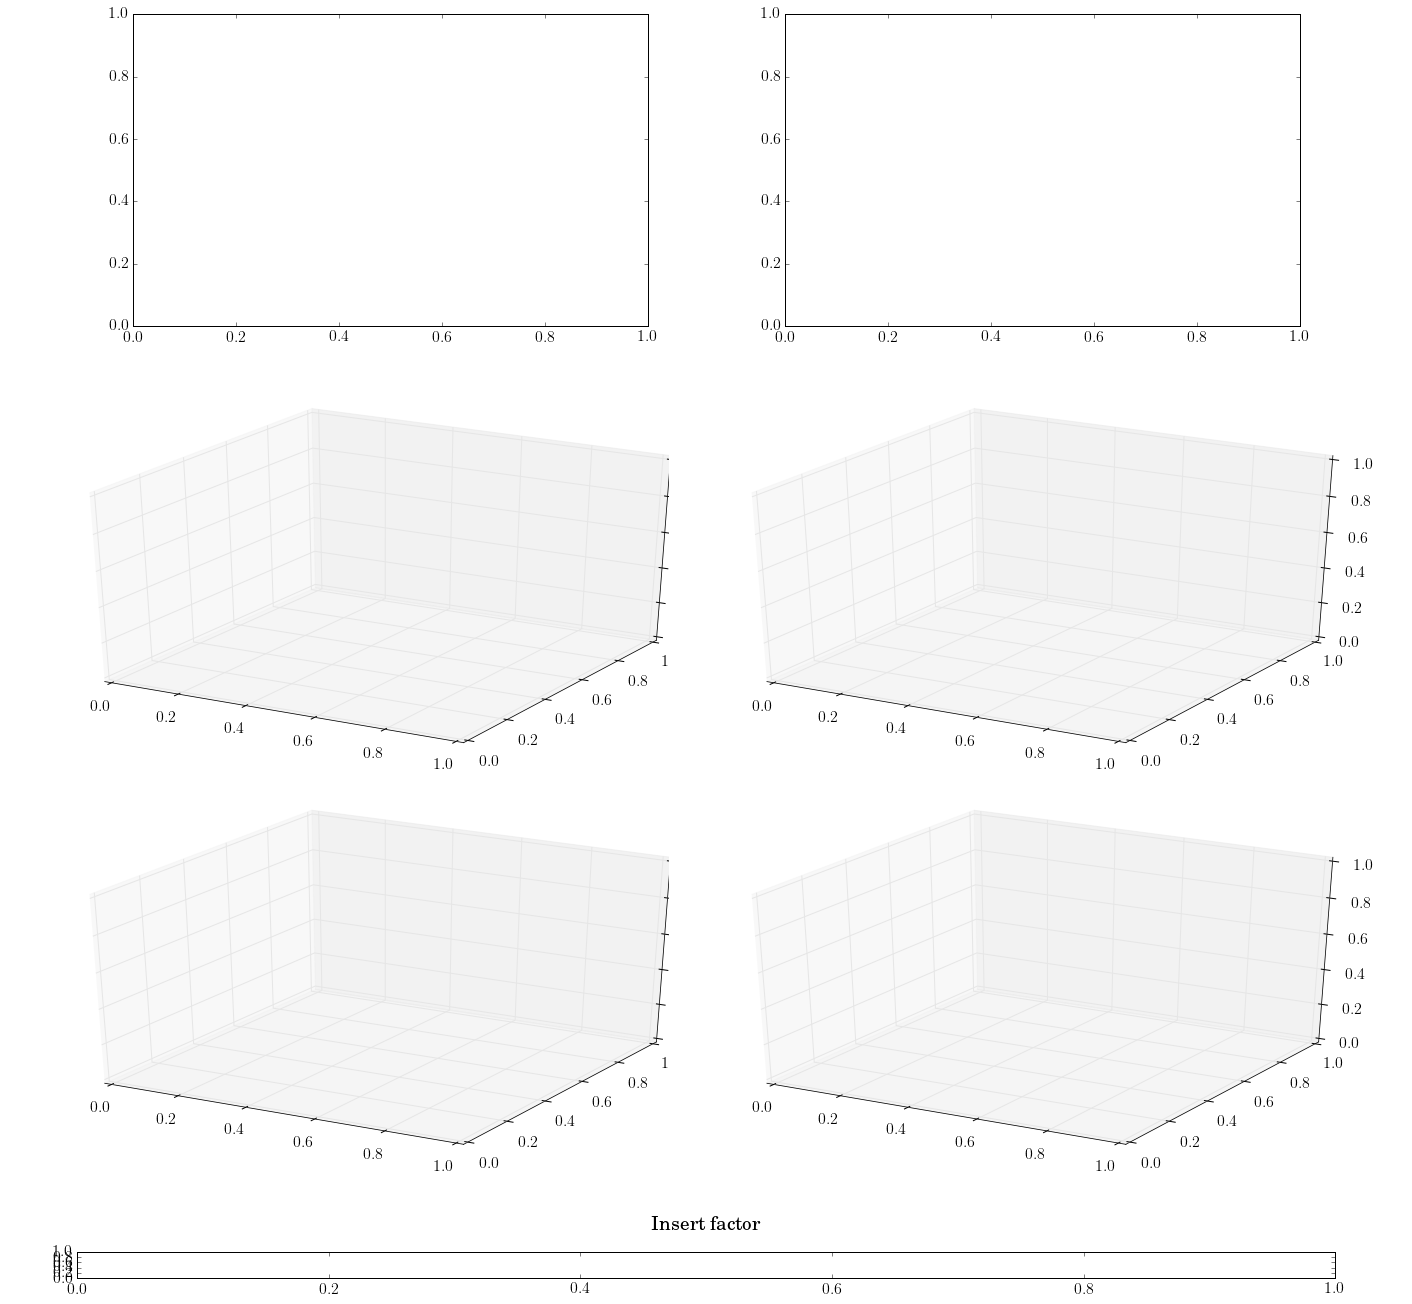

In [9]:
fig = plt.figure(figsize=(6*1.618*2,6*3))

gs1 = gridspec.GridSpec(3, 2)
gs1.update(left=0, right=1, top=1, bottom=0.085, hspace=0.05, wspace=-0.1)

ax2 = fig.add_subplot(gs1[1,0], projection='3d')
ax3 = fig.add_subplot(gs1[1,1], projection='3d')
ax4 = fig.add_subplot(gs1[2,0], projection='3d')
ax5 = fig.add_subplot(gs1[2,1], projection='3d')

gs2 = gridspec.GridSpec(3, 2)
gs2.update(left=0.09, right=0.925, top=0.975, bottom=0.23, hspace=0.05, wspace=0.265)
ax0 = fig.add_subplot(gs2[0,0])
ax1 = fig.add_subplot(gs2[0,1])


cbar_ax = fig.add_axes([0.05, 0.0, 0.9, 0.02])
cbar_ax.set_title(r'Insert factor', y=1.7)

In [10]:
model = create_model(width, eqPonA, factor)

display_fit(width, eqPonA, factor, model, fig, ax0, xlim=xlim_first, ylim=ylim_first)


In [11]:
ax0.set_title(r'Comparison of deformability between two sampled points')

pointA_coords = [2.5, 1.1]
pointB_coords = [2.9, 1.03]

pointA_deformability = fit_give(
    pointA_coords[0], pointA_coords[1], width, eqPonA, factor, 
    kx=2, ky=1, deviation=deviation)

pointB_deformability = fit_give(
    pointB_coords[0], pointB_coords[1], width, eqPonA, factor, 
    kx=2, ky=1, deviation=deviation)

ax0.scatter(*pointA_coords, marker='s', lw=2,
            s=300, alpha=1, c='red', zorder=100,
            label=r'$\varepsilon = %0.1f$ (invalid)' % (pointA_deformability))
ax0.scatter(*pointB_coords, marker='o', lw=2,
            s=340, alpha=1, c='green', zorder=100,
            label=r'$\varepsilon = %0.1f$ (valid)' % (pointB_deformability))
ax0.plot(3, 0.4,'k-', lw=2, label=r'Deformability bound ($\varepsilon = 0.5$)')

ax0.plot(
    [xlim[0], xlim[0], xlim[1], xlim[1], xlim[0]],
    [ylim[0], ylim[1], ylim[1], ylim[0], ylim[0]],
    'k--', label=r'Zoom box'
)

legend = ax0.legend(fancybox=True, loc='upper right')
legend.get_frame().set_facecolor([1,1,1,0.8])

ax0.set_xlim(xlim_first)
ax0.set_ylim(ylim_first)

(0.38, 1.2)

In [12]:
to_length([pointA_coords[0]], [pointA_coords[1]])

array([ 9.37669291])

In [13]:
to_length([pointB_coords[0]], [pointB_coords[1]])

array([ 6.61734911])

In [14]:
display_fit(width, eqPonA, factor, model, fig, ax1, xlim=xlim, ylim=ylim)
ax1.set_title(r'Zoomed in')

ax1.scatter(*pointA_coords, marker='s', lw=2,
            s=300, alpha=0.7, c='red', zorder=100, 
            label=r'$\varepsilon = %0.1f$ (invalid)' % (pointA_deformability))
ax1.scatter(*pointB_coords, marker='o', lw=2,
            s=340, alpha=0.7, c='green', zorder=100, 
            label=r'$\varepsilon = %0.1f$ (valid)' % (pointB_deformability))
ax1.plot(3, 0.4,'k-', lw=2, label=r'Deformability bound ($\varepsilon = 0.5$)')

legend = ax1.legend(fancybox=True, loc='lower left')
legend.get_frame().set_facecolor([1,1,1,0.8])

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

(0.87, 1.15)

In [15]:
def display_fit_3D(width, eqPonA, factor, model, fig, ax, 
                   give_level=None,
                   top_cut=None, bot_cut=None):    
    
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    
    if give_level is not None:
        give = fit_give(
            xx, yy, width, eqPonA, factor, kx=2, ky=1, deviation=deviation)
        give = give + give_level - 0.5 
        ax.contour(xx, yy, give, levels=[give_level], colors='k')
    
    ax.plot_surface(xx, yy, zz, rstride=10, cstride=10, alpha=1,
                    cmap=green_cm, lw=0.2, vmin=vmin, vmax=vmax, zorder=-10)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim([vmin, 0.96])

    ax.set_xlabel(r'Width (cm)')
    ax.set_ylabel(r'Perimeter / Area (cm$^{-1}$)')
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r'Insert factor', rotation=91.5)
    
    ax.grid(True)

In [16]:
pointA = model(*pointA_coords)
pointB = model(*pointB_coords)

x_cross_diff = 0.08
y_cross_diff = 0.03

azim = -100
elev = 30 # 20

linecolourA = 'black'
linecolourB = 'black'

linealpha = 0.7
linewidth = 2

sizeA = 400
sizeB = 500

In [17]:
display_fit_3D(width, eqPonA, factor, model, fig, ax2, give_level=vmin)

In [18]:
ax2.set_title(r'Before extreme point included')
ax2.scatter(
    pointA_coords[0], pointA_coords[1], pointA + deviation, 
    marker='s', s=sizeA, alpha=0.7, c='red',
    lw=2, zorder=30
)

ax2.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]-y_cross_diff, pointA_coords[1]+y_cross_diff], [pointA]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)
ax2.plot(
    [pointA_coords[0]-x_cross_diff, pointA_coords[0]+x_cross_diff], [pointA_coords[1]]*2, [pointA]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)

ax2.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]-y_cross_diff, pointA_coords[1]+y_cross_diff], [pointA+deviation]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)
ax2.plot(
    [pointA_coords[0]-x_cross_diff, pointA_coords[0]+x_cross_diff], [pointA_coords[1]]*2, [pointA+deviation]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)

ax2.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]]*2, [pointA, pointA + deviation], 
    lw=linewidth, color=linecolourA, ls='--', alpha=linealpha, zorder=20)

ax2.view_init(elev=elev, azim=azim)

In [19]:
extreme_modelA = create_model(
    np.append(width, pointA_coords[0]), 
    np.append(eqPonA, pointA_coords[1]), 
    np.append(factor, pointA+deviation))
display_fit_3D(width, eqPonA, factor, extreme_modelA, fig, ax3, give_level=vmin)

ax3.set_title(r'After extreme point included')

ax3.scatter(
    pointA_coords[0], pointA_coords[1], pointA + deviation, 
    marker='s', s=sizeA, alpha=0.7, c='red',
    lw=2, zorder=30
)

ax3.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]-y_cross_diff, pointA_coords[1]+y_cross_diff], 
    [pointA]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)
ax3.plot(
    [pointA_coords[0]-x_cross_diff, pointA_coords[0]+x_cross_diff], [pointA_coords[1]]*2, 
    [pointA]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)

ax3.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]-y_cross_diff, pointA_coords[1]+y_cross_diff], 
    [pointA+deviation]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)
ax3.plot(
    [pointA_coords[0]-x_cross_diff, pointA_coords[0]+x_cross_diff], [pointA_coords[1]]*2, 
    [pointA+deviation]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)

ax3.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]-y_cross_diff, pointA_coords[1]+y_cross_diff], 
    [extreme_modelA(*pointA_coords)]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)
ax3.plot(
    [pointA_coords[0]-x_cross_diff, pointA_coords[0]+x_cross_diff], [pointA_coords[1]]*2, 
    [extreme_modelA(*pointA_coords)]*2, 
    color=linecolourA, lw=linewidth, alpha=linealpha, zorder=20)

ax3.plot(
    [pointA_coords[0]]*2, [pointA_coords[1]]*2, [pointA, pointA + deviation], 
    lw=linewidth, color=linecolourA, ls='--', alpha=linealpha, zorder=20)

ax3.view_init(elev=elev, azim=azim)

(extreme_modelA(*pointA_coords) - pointA) / deviation

# fig

0.70790805010412794

In [20]:
display_fit_3D(width, eqPonA, factor, model, fig, ax4, give_level=vmin)

ax4.set_title(r'Before extreme point included')

ax4.scatter(
    pointB_coords[0], pointB_coords[1], pointB + deviation, 
    marker='o', s=sizeB, alpha=0.7, c='green',
    lw=2, zorder=30
)

ax4.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]-y_cross_diff, pointB_coords[1]+y_cross_diff], [pointB]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)
ax4.plot(
    [pointB_coords[0]-x_cross_diff, pointB_coords[0]+x_cross_diff], [pointB_coords[1]]*2, [pointB]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)

ax4.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]-y_cross_diff, pointB_coords[1]+y_cross_diff], [pointB+deviation]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)
ax4.plot(
    [pointB_coords[0]-x_cross_diff, pointB_coords[0]+x_cross_diff], [pointB_coords[1]]*2, [pointB+deviation]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)

ax4.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]]*2, [pointB, pointB + deviation], 
    lw=linewidth, color=linecolourB, ls='--', alpha=linealpha, zorder=20)

ax4.view_init(elev=elev, azim=azim)



# fig

In [21]:
extreme_modelB = create_model(
    np.append(width, pointB_coords[0]), np.append(eqPonA, pointB_coords[1]), np.append(factor, pointB+deviation))

display_fit_3D(width, eqPonA, factor, extreme_modelB, fig, ax5, give_level=vmin)

In [22]:
ax5.set_title(r'After extreme point included')

ax5.scatter(
    pointB_coords[0], pointB_coords[1], pointB + deviation, 
    marker='o', s=sizeB, alpha=0.7, c='green',
    lw=2, zorder=30
)

ax5.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]-y_cross_diff, pointB_coords[1]+y_cross_diff], 
    [pointB]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)
ax5.plot(
    [pointB_coords[0]-x_cross_diff, pointB_coords[0]+x_cross_diff], [pointB_coords[1]]*2, 
    [pointB]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)

ax5.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]-y_cross_diff, pointB_coords[1]+y_cross_diff], 
    [pointB+deviation]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)
ax5.plot(
    [pointB_coords[0]-x_cross_diff, pointB_coords[0]+x_cross_diff], [pointB_coords[1]]*2, 
    [pointB+deviation]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)

ax5.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]-y_cross_diff, pointB_coords[1]+y_cross_diff], 
    [extreme_modelB(*pointB_coords)]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)
ax5.plot(
    [pointB_coords[0]-x_cross_diff, pointB_coords[0]+x_cross_diff], [pointB_coords[1]]*2, 
    [extreme_modelB(*pointB_coords)]*2, 
    color=linecolourB, lw=linewidth, alpha=linealpha, zorder=20)

ax5.plot(
    [pointB_coords[0]]*2, [pointB_coords[1]]*2, 
    [pointB, pointB + deviation], 
    lw=linewidth, color=linecolourB, ls='--', alpha=linealpha, zorder=20)


ax5.view_init(elev=elev, azim=azim)
(extreme_modelB(*pointB_coords) - pointB) / deviation

# fig

0.39803393187469172

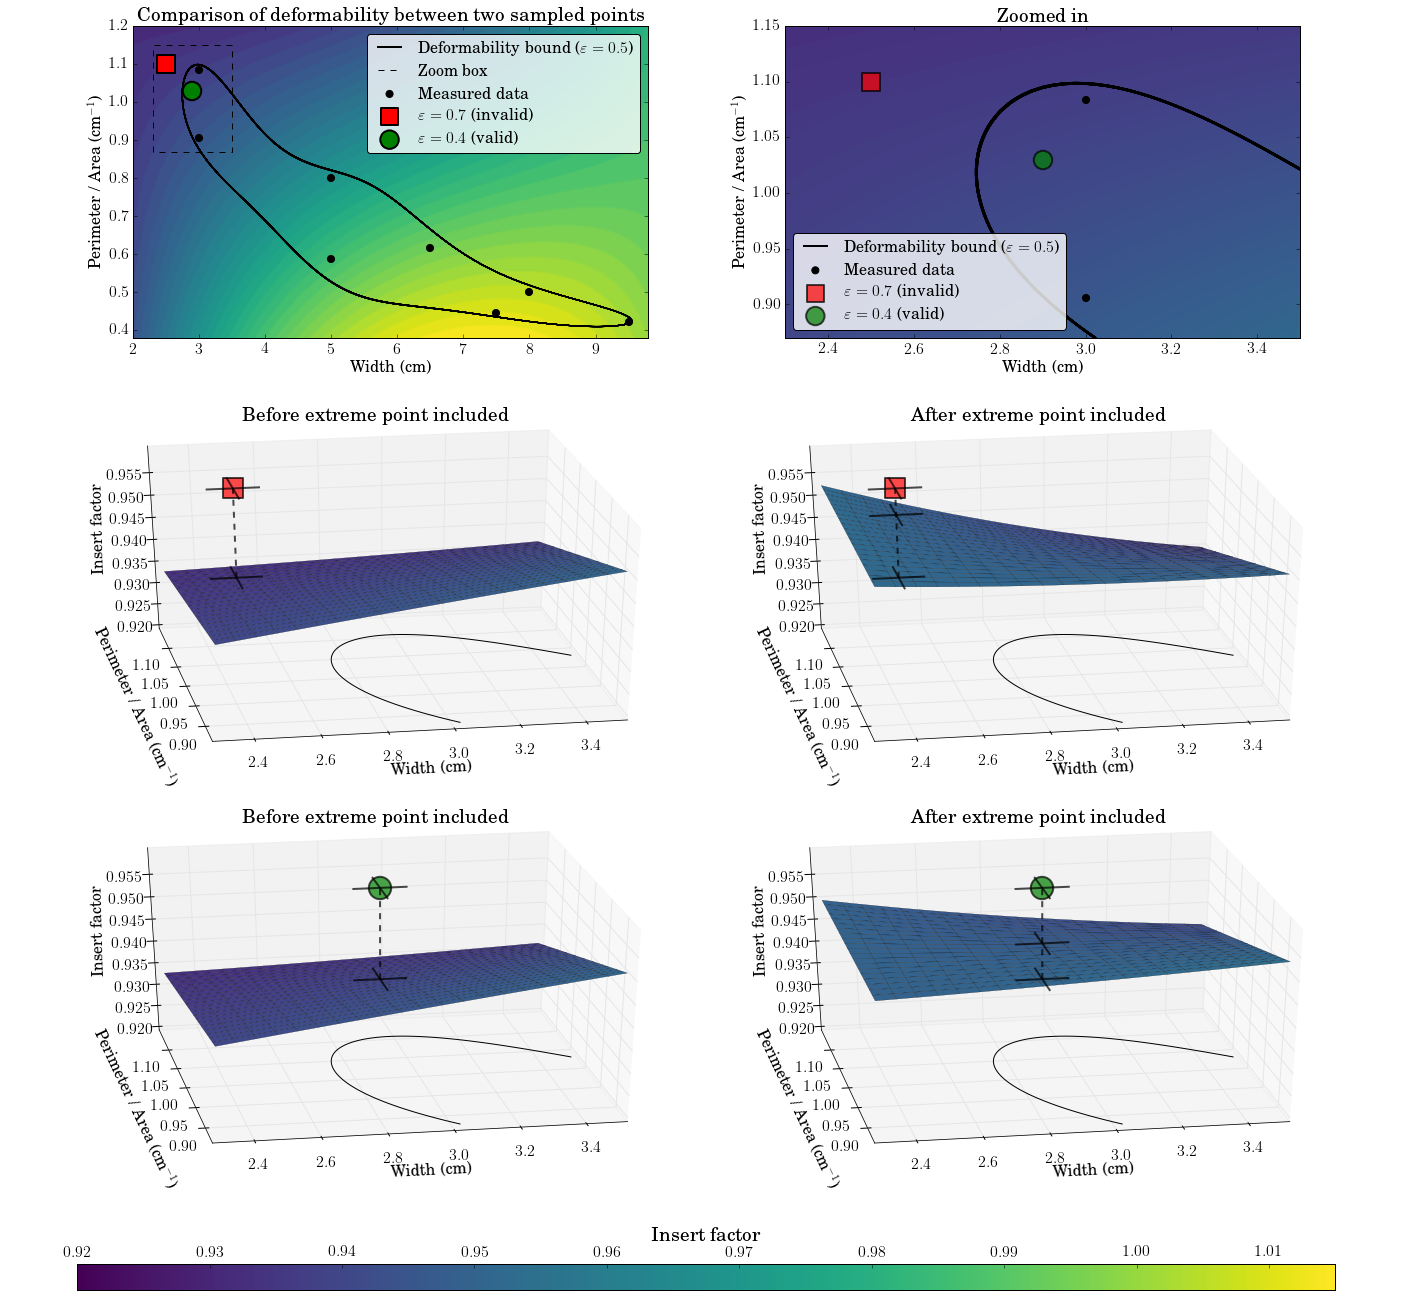

In [23]:
fig

In [24]:
fig.savefig('figures/deformability_example.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/deformability_example.eps', bbox_inches='tight', dpi=300)